<a href="https://colab.research.google.com/github/DrFabach/sciDoCours/blob/master/Intro_keras_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
%matplotlib inline
%tensorflow_version 2.x

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


# Introduction à keras



Le but de ce TP est d'introduire l'utilisation de la library Keras pour le deep-learning. Nous utiliserons cette library à travers 2 exemples de réseaux sur le dataset MNIST

## La tâche

Construire un modèle de réseau de neurones artificiel pour classifier les chiffres manuscrits. 
Nous disposons du dataset MNIST qui contient 60,000 images pour le train et 10,000 images pour le test. 


<img src="https://github.com/AviatorMoser/keras-mnist-tutorial/blob/master/mnist.png?raw=1" >

### Import des modules python requis


In [26]:
import numpy as np                   
import matplotlib.pyplot as plt     
import random                       

import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix


## Charger les datasets d'entrainement et de test

Le dataset MNIST est un dataset jouet. Il est fourni directement dans keras. On peut donc le charger avec la 2 fonctions: `mnist = tf.keras.datasets.mnist` puis `mnist.load_data()`


In [27]:
# The MNIST data is split between 60,000 28 x 28 pixel training images and 10,000 28 x 28 pixel images
mnist = tf.keras.datasets.mnist

(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

print("X_train shape", X_train.shape)
print("y_train shape", Y_train.shape)
print("X_test shape", X_test.shape)
print("y_test shape", Y_test.shape)

X_train shape (60000, 28, 28)
y_train shape (60000,)
X_test shape (10000, 28, 28)
y_test shape (10000,)


Avec matplotlib, on peut afficher quelques images d'exemple en utilisant la fonction ci-dessous:

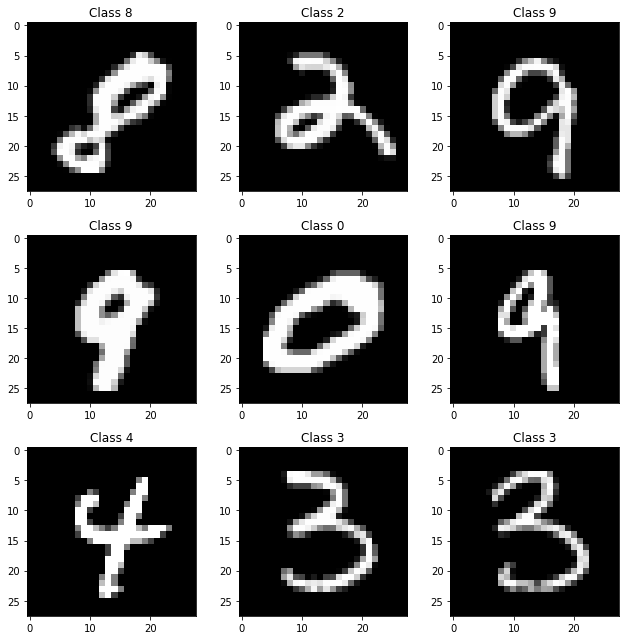

In [28]:
plt.rcParams['figure.figsize'] = (9,9) # pour que les images s'affichent en plus grand dans le notebook

random.seed(3)
nums = [random.randint(0, len(X_train)) for x in range(9)]

for i, num in enumerate(nums):
    plt.subplot(3,3,i+1)
    plt.imshow(X_train[num], cmap='gray', interpolation='none')
    plt.title("Class {}".format(Y_train[num]))
    
plt.tight_layout()

Affichons la matrice correspondant à un seul chiffre

In [29]:
# une petite fonction pour afficher les matrices joliment
def matprint(mat, fmt="g"):
    col_maxes = [max([len(("{:"+fmt+"}").format(x)) for x in col]) for col in mat.T]
    for x in mat:
        for i, y in enumerate(x):
            print(("{:"+str(col_maxes[i])+fmt+"}").format(y), end="  ")
        print("")

# now print!        
matprint(X_train[nums[2]])

0  0  0  0  0  0  0    0    0    0    0    0    0    0    0    0    0    0    0    0    0  0  0  0  0  0  0  0  
0  0  0  0  0  0  0    0    0    0    0    0    0    0    0    0    0    0    0    0    0  0  0  0  0  0  0  0  
0  0  0  0  0  0  0    0    0    0    0    0    0    0    0    0    0    0    0    0    0  0  0  0  0  0  0  0  
0  0  0  0  0  0  0    0    0    0    0    0    0    0    0    0    0    0    0    0    0  0  0  0  0  0  0  0  
0  0  0  0  0  0  0    0    0    0    0    0    0    0    0    0    0    0    0    0    0  0  0  0  0  0  0  0  
0  0  0  0  0  0  0    0    0    0    0    0    0    0    0    0    0    0    0    0    0  0  0  0  0  0  0  0  
0  0  0  0  0  0  0    0    0    0    0   49  138  191  244  138   55   15    0    0    0  0  0  0  0  0  0  0  
0  0  0  0  0  0  0    0    0    5   68  228  252  252  253  252  252  219   15    0    0  0  0  0  0  0  0  0  
0  0  0  0  0  0  0    0    0  138  252  252  153   69   69   90  202  252   54    0    0  0  0 

Chaque pixel est un 8-bit integer dans le range 0-255. 0 = Noir, 255 = Blanc.



## Reformater l'input

Pour simplifier l'architecture du réseau, nous allons reformater les images.

Transformer les matrices 28 x 28 en vecteurs de taille 784.

Puis normaliser les valeurs vers un range [0-1]


<img src='https://github.com/AviatorMoser/keras-mnist-tutorial/blob/master/flatten.png?raw=1' >

In [30]:
X_train = X_train.reshape(60000, 784) 
X_test = X_test.reshape(10000, 784)   

X_train, X_test = X_train / 255.0, X_test / 255.0

print("Training matrix shape", X_train.shape)
print("Testing matrix shape", X_test.shape)

Training matrix shape (60000, 784)
Testing matrix shape (10000, 784)


# Construisons un premier réseau


## Initialiser le modèle avec `Sequential()`

Sequential permet de construire des réseaux linéaires: une entrée - des traitements - une sortie.

Pour des architectures plus complexes, il faut aller voir du côté de l'api `Functional` [Keras functional API](https://www.tensorflow.org/guide/keras/functional)



In [31]:
# PARAMETRES 

params = {'dense_size': 64, 
          'dense_layers':2}

In [32]:
params['dense_size']

64

In [33]:
model = tf.keras.models.Sequential()

## Ajouter des couches au modèle

In [34]:
model.add(
    tf.keras.layers.Dense(params['dense_size'], input_shape=(784,))
    ) # une couche dense (fully connected) de taille 64

![Texte alternatif…](https://slugnet.jarrodkahn.com/_images/tikz-be0593f4dad31d763e7f8371668007610e7907c1.png)

Notez que pour la première couche il faut préciser la forme des données. Ici, nous avons des données de dimension 1 (vecteurs) et de taille 784. (Si nous avions des données en dimension 2 nous aurions eu une valeur de shape du type `(28,28)`


## Ajouter une activation (Relu)

![Texte alternatif…](https://miro.medium.com/max/1192/1*4ZEDRpFuCIpUjNgjDdT2Lg.png)

In [35]:
model.add(
    tf.keras.layers.Activation('relu')
    )

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 64)                50240     
                                                                 
 activation_8 (Activation)   (None, 64)                0         
                                                                 
Total params: 50,240
Trainable params: 50,240
Non-trainable params: 0
_________________________________________________________________


In [36]:
for l in range(params['dense_layers']): 
  model.add(
    tf.keras.layers.Dense(params['dense_size'])
    )
  model.add(
      tf.keras.layers.Activation('relu')
      )


## Ajouter une couche de Dropout

Le dropout est une technique de régularisation qui permet d'éviter l'overfitting. Elle consiste à "oublier" aléatoirement un certain nombre de poids du réseau

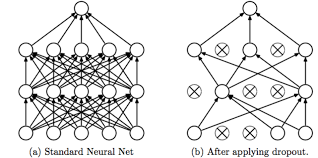

In [37]:
model.add(
    tf.keras.layers.Dropout(0.5)
)

In [38]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 64)                50240     
                                                                 
 activation_8 (Activation)   (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 64)                4160      
                                                                 
 activation_9 (Activation)   (None, 64)                0         
                                                                 
 dense_7 (Dense)             (None, 64)                4160      
                                                                 
 activation_10 (Activation)  (None, 64)                0         
                                                                 
 dropout_1 (Dropout)         (None, 64)               

## Ajouter le classifieur 

Pour le moment, nous avons encodé notre input à l'aide de nos premières couches mais il faut à présent projeter cette représentation dans l'espace des labels (cible) afin de faire un prédiction 

In [39]:
model.add(
    tf.keras.layers.Dense(10))
model.add(
    tf.keras.layers.Activation('softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 64)                50240     
                                                                 
 activation_8 (Activation)   (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 64)                4160      
                                                                 
 activation_9 (Activation)   (None, 64)                0         
                                                                 
 dense_7 (Dense)             (None, 64)                4160      
                                                                 
 activation_10 (Activation)  (None, 64)                0         
                                                                 
 dropout_1 (Dropout)         (None, 64)               

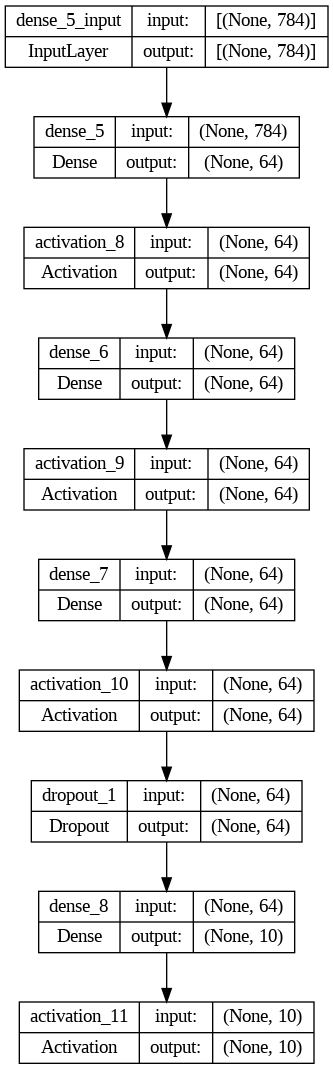

In [40]:
tf.keras.utils.plot_model(model, 'model1.png', show_shapes=True)

## Compiler le modèle pour obtenir un modèle executable
Il faut préciser la fonction de coût à utiliser. C'est la fonction qui va être dérivée pour obtenir les gradients d'opitimisation. Elle dépend de la tâche. Ici nous cherchons à faire une classification à plusieurs catégories, il faut donc utiliser une `categorical_crossentropy`. Et comme nos Y sont codés en [1,2,3,...] il faut utiliser la fonction `sparse_categorical_crossentropy`. Pour plus d'info: [loss-and-loss-functions-for-training-deep-learning-neural-networks](https://machinelearningmastery.com/loss-and-loss-functions-for-training-deep-learning-neural-networks/)

Il faut aussi préciser l'algorithme à utiliser pour optimiser les poids (des variantes de gradient descent), ici `adam`

et enfin préciser la métrique d'évaluation, ici `accuracy`

In [41]:
model.compile(loss='sparse_categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

## Entrainer le modèle 

Nous pouvons enfin entrainer notre premier modèle


In [42]:
model.fit(X_train,        # input
          Y_train,        # output
          batch_size=128, # taille des minibatches
          epochs=5,       # nombre d'epochs (passages sur les données )
          verbose=1)      # option paramètrant la quantité d'informations à afficher pendant l'entrainement

Epoch 1/5
469/469 [==============================] - 2s 3ms/step - loss: 0.5682 - accuracy: 0.8296
Epoch 2/5
469/469 [==============================] - 1s 3ms/step - loss: 0.2160 - accuracy: 0.9402
Epoch 3/5
469/469 [==============================] - 1s 3ms/step - loss: 0.1580 - accuracy: 0.9567
Epoch 4/5
469/469 [==============================] - 1s 3ms/step - loss: 0.1280 - accuracy: 0.9652
Epoch 5/5
469/469 [==============================] - 1s 3ms/step - loss: 0.1090 - accuracy: 0.9700


## Evaluer le modèle sur les données test

In [43]:
score = model.evaluate(X_test, Y_test)
print('Test score:', score[0])
print('Test accuracy:', score[1])

313/313 [==============================] - 1s 2ms/step - loss: 0.0976 - accuracy: 0.9709
Test score: 0.09760664403438568
Test accuracy: 0.9708999991416931


## Inspecter les résultats plus précisément avec `classification_report` et `confusion_matrix`

In [44]:
from sklearn.metrics import classification_report, confusion_matrix

predicted_classes = model.predict(X_test)
predicted_classes


313/313 [==============================] - 0s 1ms/step


array([[3.0596425e-07, 2.8660759e-07, 1.2695473e-05, ..., 9.9995732e-01,
        2.0406333e-07, 2.3530536e-06],
       [7.0607666e-07, 4.1064486e-05, 9.9952018e-01, ..., 1.2158753e-05,
        2.7640881e-06, 5.3216576e-10],
       [3.3864726e-05, 9.9290508e-01, 2.2852662e-04, ..., 1.5538307e-03,
        1.8605217e-04, 1.1926796e-04],
       ...,
       [1.5501622e-10, 6.3428764e-08, 3.2803746e-09, ..., 6.3496526e-07,
        1.9017472e-08, 1.6082304e-04],
       [1.2415898e-06, 1.2549158e-07, 1.1189424e-08, ..., 1.3757787e-09,
        1.6601645e-05, 3.5567734e-07],
       [2.3845621e-08, 7.2557488e-10, 1.2009168e-08, ..., 7.4391812e-11,
        5.9667573e-09, 2.4009199e-07]], dtype=float32)

In [45]:
predicted_classes = model.predict(X_test).argmax(axis=1)

print(confusion_matrix(Y_test, predicted_classes))
print(classification_report(Y_test, predicted_classes))


313/313 [==============================] - 1s 3ms/step
[[ 965    0    3    0    0    2    4    1    3    2]
 [   0 1121    4    1    0    0    3    1    5    0]
 [   6    2 1003    4    3    0    1    7    6    0]
 [   1    0    7  969    0   16    0    7    6    4]
 [   2    0    5    0  968    0    1    1    1    4]
 [   6    0    0    3    2  859    8    4    6    4]
 [   7    1    0    1    9    3  936    0    1    0]
 [   0    3    8    4    2    0    0  982    2   27]
 [   4    0    2    7    7    6    7    3  934    4]
 [   2    4    0    3   14    7    0    6    1  972]]
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.97      0.97      0.97      1032
           3       0.98      0.96      0.97      1010
           4       0.96      0.99      0.97       982
           5       0.96      0.96      0.96       892
           6       0.97      0.98  

# TODO

## Plot quelques exemples correctement et incorrectement classifiés

## Faites varier les paramètres du réseau pour essayer d'obtenir de meilleurs résultats

Ici les paramètres que l'on peut faire varier comprennent: 
- La taille de la couche dense
- Le nombre de couches denses 
- La fonction d'activation de la/les couches denses
- Les valeurs de Dropout 
- La taille des batchs 
- La fonction d'optimisation 

In [46]:
np.nonzero(predicted_classes != Y_test)[0]

array([   8,  151,  241,  247,  259,  321,  381,  445,  449,  495,  582,
        659,  691,  720,  846,  938,  947,  951,  956,  965, 1014, 1032,
       1039, 1055, 1107, 1128, 1156, 1166, 1182, 1194, 1226, 1232, 1242,
       1247, 1260, 1289, 1299, 1319, 1328, 1364, 1378, 1393, 1414, 1425,
       1494, 1500, 1522, 1527, 1530, 1531, 1549, 1553, 1569, 1609, 1681,
       1709, 1717, 1751, 1754, 1790, 1800, 1878, 1883, 1901, 1911, 1941,
       1952, 1987, 2004, 2024, 2040, 2044, 2053, 2070, 2098, 2109, 2118,
       2125, 2182, 2185, 2266, 2272, 2291, 2293, 2329, 2369, 2387, 2406,
       2408, 2422, 2433, 2488, 2607, 2618, 2635, 2648, 2654, 2730, 2863,
       2896, 2915, 2921, 2927, 2930, 2939, 2945, 2953, 3005, 3012, 3073,
       3117, 3206, 3225, 3330, 3333, 3336, 3376, 3422, 3451, 3503, 3520,
       3549, 3558, 3559, 3567, 3597, 3629, 3718, 3727, 3749, 3751, 3757,
       3767, 3769, 3776, 3780, 3808, 3818, 3838, 3855, 3869, 3876, 3906,
       3943, 3995, 4065, 4075, 4093, 4102, 4139, 41

In [47]:
correct_indices = np.nonzero(predicted_classes == Y_test)[0]

incorrect_indices = np.nonzero(predicted_classes != Y_test)[0]

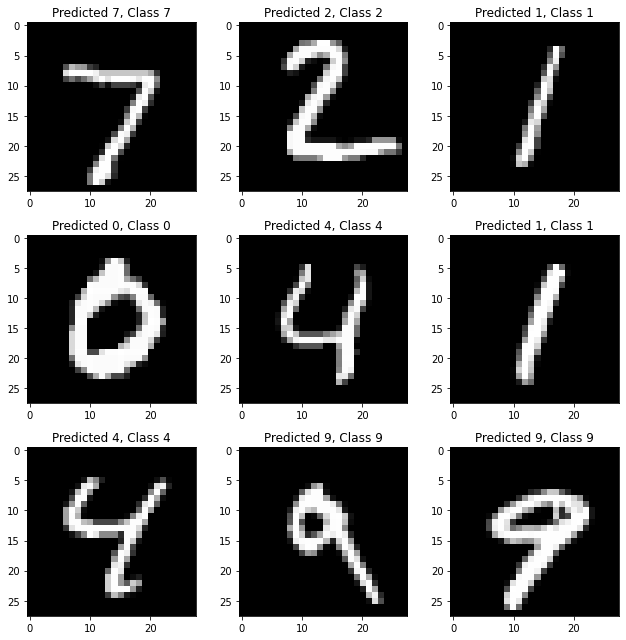

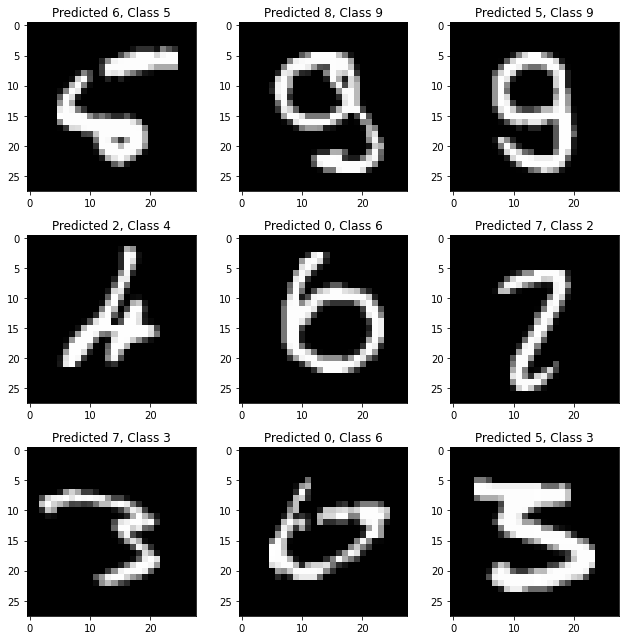

In [48]:
plt.figure()
for i, correct in enumerate(correct_indices[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[correct].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[correct], Y_test[correct]))
    
plt.tight_layout()


plt.figure()
for i, incorrect in enumerate(incorrect_indices[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[incorrect].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[incorrect], Y_test[incorrect]))
    
plt.tight_layout()

# Passons à la convolution









Le but de la convolution est de générer des cartes de features basées sur les pixels originaux mais permettant d'obtenir des informations plus riches (courbes, angles, côtés,...) 

![Texte alternatif…](https://miro.medium.com/max/2340/1*Fw-ehcNBR9byHtho-Rxbtw.gif)

Dans l'exemple ci-dessus, on part d'une matrice 5x5 et on fait passer un kernel de convolution de taille 3x3. Le résultat de la convolution est un dot product entre la matrice et le kernel. On déplace le kernel sur l'image afin la couvrir en totalité. 

```python
tf.keras.layers.Conv2D(32,                      # on crée 32 filtres
                       (3, 3),                  # kernel de taille (3,3)
                       input_shape=(28,28,1)))
```


Les convolutions sont appliquées avec ensuite une couche de **max-pooling** (cf illustration ci-dessous)

![Texte alternatif…](https://developers.google.com/machine-learning/practica/image-classification/images/maxpool_animation.gif)

```python
tf.keras.layers.MaxPooling2D(pool_size=(2,2))
```

En général les modules de convolution se présentent comme cela: 

```
Convolution 
Activation
Convolution
Activation
Pooling
```

On peut mettre autant de modules que l'on veut


A la fin d'une série de convolutions/pooling, il faut applanir l'output avant de le faire passer dans une couche dense. Pour cela, la fonction `tf.keras.Flatten` est utile

## Preprocessing pour le réseau de convolution

### Recharger le dataset

In [51]:
# Recharger le dataset
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

### Reformater les inputs vers (n_sample,28,28,1) et normaliser
n_sample = nombre d'exemples dans le dataset
28x28 = taille de la matrice
1 = nombre de couches (ici ce sont des images en noir et blanc, donc une seule couche) 

In [52]:
X_train = X_train.reshape(60000, 28, 28, 1) # Ajouter une dimension supplémentaire pour représenter la couche unique
X_test = X_test.reshape(10000, 28, 28, 1)

X_train, X_test = X_train / 255.0, X_test / 255.0

print("Training matrix shape", X_train.shape)
print("Testing matrix shape", X_test.shape)

Training matrix shape (60000, 28, 28, 1)
Testing matrix shape (10000, 28, 28, 1)


In [53]:
model = tf.keras.models.Sequential()                                 

# Convolution Layer 1
model.add(
    tf.keras.layers.Conv2D(32, (3, 3), input_shape=(28,28,1)))            
model.add(
    tf.keras.layers.Activation('relu') )                   

# Convolution Layer 2
model.add(
    tf.keras.layers.Conv2D(32, (3, 3)))                                    
model.add(
    tf.keras.layers.Activation('relu'))                         
model.add(
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)))         

model.add(
    tf.keras.layers.Flatten())                                

# Fully Connected Layer 5
model.add(
    tf.keras.layers.Dense(64))                                               
model.add(
    tf.keras.layers.Activation('relu'))                      

# Fully Connected Layer 6                       
model.add(
    tf.keras.layers.Dropout(0.2))                            
model.add(
    tf.keras.layers.Dense(10))                                
model.add(
    tf.keras.layers.Activation('softmax'))     

In [55]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, Y_train,  epochs=5, verbose=1)
predicted_classes = model.predict(X_test).argmax(axis=1)

print(confusion_matrix(Y_test, predicted_classes))
print(classification_report(Y_test, predicted_classes))

Epoch 1/5
1875/1875 [==============================] - 7s 3ms/step - loss: 0.0253 - accuracy: 0.9916
Epoch 2/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0220 - accuracy: 0.9928
Epoch 3/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0180 - accuracy: 0.9937
Epoch 4/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0150 - accuracy: 0.9948
Epoch 5/5
313/313 [==============================] - 1s 2ms/step
[[ 978    0    0    1    0    0    0    0    1    0]
 [   1 1130    1    1    0    1    1    0    0    0]
 [   2    1 1016    1    1    0    0    8    3    0]
 [   1    0    2  995    0    8    0    3    1    0]
 [   0    0    0    0  971    0    2    1    3    5]
 [   1    0    0    2    0  884    4    0    1    0]
 [   4    2    0    1    1    2  947    0    1    0]
 [   0    2    4    0    1    0    0 1015    1    5]
 [   4    1    0    1    0    0    0    1  965    2]
 [   1    0    0    0    5    3    0    4    7  989]]


Epoch 1/50
4020/4020 [==============================] - 18s 5ms/step - loss: 0.0072 - accuracy: 0.9977 - val_loss: 0.0547 - val_accuracy: 0.9914
Epoch 2/50
4020/4020 [==============================] - 17s 4ms/step - loss: 0.0057 - accuracy: 0.9983 - val_loss: 0.0582 - val_accuracy: 0.9909
Epoch 3/50
4020/4020 [==============================] - 17s 4ms/step - loss: 0.0070 - accuracy: 0.9982 - val_loss: 0.0594 - val_accuracy: 0.9903
Epoch 4/50
4020/4020 [==============================] - 17s 4ms/step - loss: 0.0056 - accuracy: 0.9983 - val_loss: 0.0553 - val_accuracy: 0.9920
Epoch 5/50
4020/4020 [==============================] - 18s 4ms/step - loss: 0.0075 - accuracy: 0.9978 - val_loss: 0.0702 - val_accuracy: 0.9913
Epoch 6/50
4020/4020 [==============================] - 19s 5ms/step - loss: 0.0073 - accuracy: 0.9978 - val_loss: 0.0544 - val_accuracy: 0.9925
Epoch 7/50
4020/4020 [==============================] - 18s 5ms/step - loss: 0.0056 - accuracy: 0.9983 - val_loss: 0.0834 - val_ac

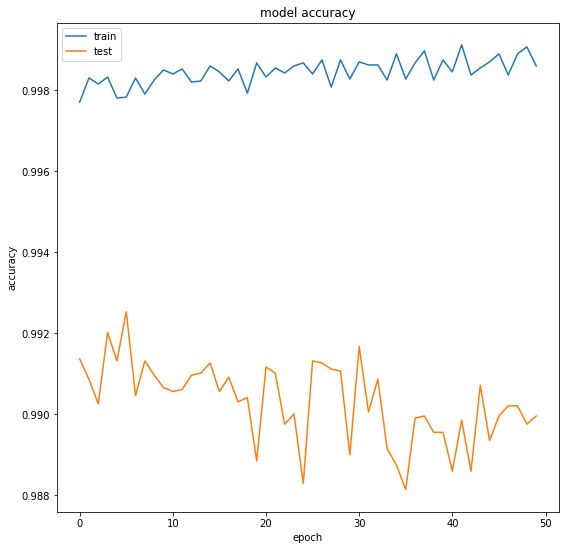

In [58]:
history = model.fit(X_train, Y_train, validation_split=0.33, epochs=50, batch_size=10, verbose=1)
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 activation_14 (Activation)  (None, 26, 26, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 32)        9248      
                                                                 
 activation_15 (Activation)  (None, 24, 24, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 32)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 4608)              0         
                                                      

# TODO

## Evaluer le modèle et interpréter les résultats

## Faites varier les paramètres du réseau pour essayer d'obtenir de meilleurs résultats

Ici les paramètres que l'on peut faire varier comprennent: 
- Convolution:
  - Nombre de filtres, 
  - taille du kernel
- Pooling: 
  - Fonction de pooling
  - taille de pooling
- Nombre de couches de convolution
- la fonction d'activation des couches de convolution
- La taille de la couche dense
- Le nombre de couches denses 
- La fonction d'activation de la/les couches denses
- Les valeurs de Dropout 
- La taille des batchs 
- La fonction d'optimisation 

## Pour aller plus loin: 
- Tester la `BatchNormalization` [https://keras.io/layers/normalization/](https://keras.io/layers/normalization/)
- Utiliser un générateur `ImageDataGenerator` pour augmenter le train set en faisant varier les paramètres des images (taille, rotation, zoom, ...). Il faudra aussi adapter la fonction de fit du modèle et utiliser `fit_generator`

In [ ]:
# data augmentation prevents overfitting by slightly changing the data randomly
# Keras has a great built-in feature to do automatic augmentation

gen = ImageDataGenerator(rotation_range=8, width_shift_range=0.08, shear_range=0.3,
                         height_shift_range=0.08, zoom_range=0.08)

test_gen = ImageDataGenerator()

In [ ]:
# We can then feed our augmented data in batches
# Besides loss function considerations as before, this method actually results in significant memory savings
# because we are actually LOADING the data into the network in batches before processing each batch

# Before the data was all loaded into memory, but then processed in batches.

train_generator = gen.flow(X_train, Y_train, batch_size=128)
test_generator = test_gen.flow(X_test, Y_test, batch_size=128)

In [ ]:
# We can now train our model which is fed data by our batch loader
# Steps per epoch should always be total size of the set divided by the batch size

# SIGNIFICANT MEMORY SAVINGS (important for larger, deeper networks)

model.fit_generator(train_generator, steps_per_epoch=60000//128, epochs=5, verbose=1, 
                    validation_data=test_generator, validation_steps=10000//128)

In [ ]:
score = model.evaluate(X_test, Y_test)
print('Test score:', score[0])
print('Test accuracy:', score[1])

10000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================